In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Load the CSV file
df = pd.read_csv(r'C:\Users\farrel.mahardika\tdm_presence_aliased.csv')

# Convert 'Tanggal' to datetime format
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')

# Convert time columns to datetime format
def to_time(x):
    try:
        return pd.to_datetime(x, format='%H:%M').time()
    except:
        return np.nan

df['Jam Masuk'] = df['Jam Masuk'].apply(to_time)
df['Jam Pulang'] = df['Jam Pulang'].apply(to_time)
df['Absen Masuk'] = df['Absen Masuk'].apply(to_time)
df['Absen Pulang'] = df['Absen Pulang'].apply(to_time)

# Replace null 'Terlambat' with appropriate time
def time_diff(start_time, end_time):
    if pd.isna(start_time) or pd.isna(end_time):
        return np.nan
    start = datetime.combine(datetime.today(), start_time)
    end = datetime.combine(datetime.today(), end_time)
    return (end - start).total_seconds() / 3600

def calculate_terlambat(row):
    if pd.isna(row['Jam Masuk']):
        return np.nan
    if row['Jam Masuk'] > datetime.strptime('10:00', '%H:%M').time():
        return time_diff(row['Jam Masuk'], datetime.strptime('10:00', '%H:%M').time())
    return np.nan

df['Terlambat'] = df.apply(calculate_terlambat, axis=1)

# Replace null 'Total Jam' with the difference between 'Absen Masuk' and 'Absen Pulang'
def calculate_total_jam(row):
    if pd.isna(row['Absen Masuk']) or pd.isna(row['Absen Pulang']):
        return np.nan
    return time_diff(row['Absen Masuk'], row['Absen Pulang'])

df['Total Jam'] = df.apply(calculate_total_jam, axis=1)

# Replace null 'Kurang Jam'
def calculate_kurang_jam(total_jam):
    if pd.isna(total_jam):
        return np.nan
    return max(0, 9 - total_jam)

df['Kurang Jam'] = df['Total Jam'].apply(calculate_kurang_jam)

#Check for not in and not out
df.loc[df['Status'] == 'Not In', 'Absen Masuk'] = np.nan
df.loc[df['Status'] == 'Not Out', 'Absen Pulang'] = np.nan

# Convert clock-in times to hours for plotting
def time_to_hours(t):
    if pd.isna(t):
        return np.nan
    return t.hour + t.minute / 60

df['Clock In Hours'] = df['Absen Masuk'].apply(time_to_hours)

# Filter out irrelevant statuses
df_filtered = df[~df['Status'].isin(['Libur', 'CB', 'SAKIT', 'WFS'])].copy()

# Format the date to "MM-DD"
df_filtered.loc[:, 'Tanggal'] = df_filtered['Tanggal'].dt.strftime('%m-%d')

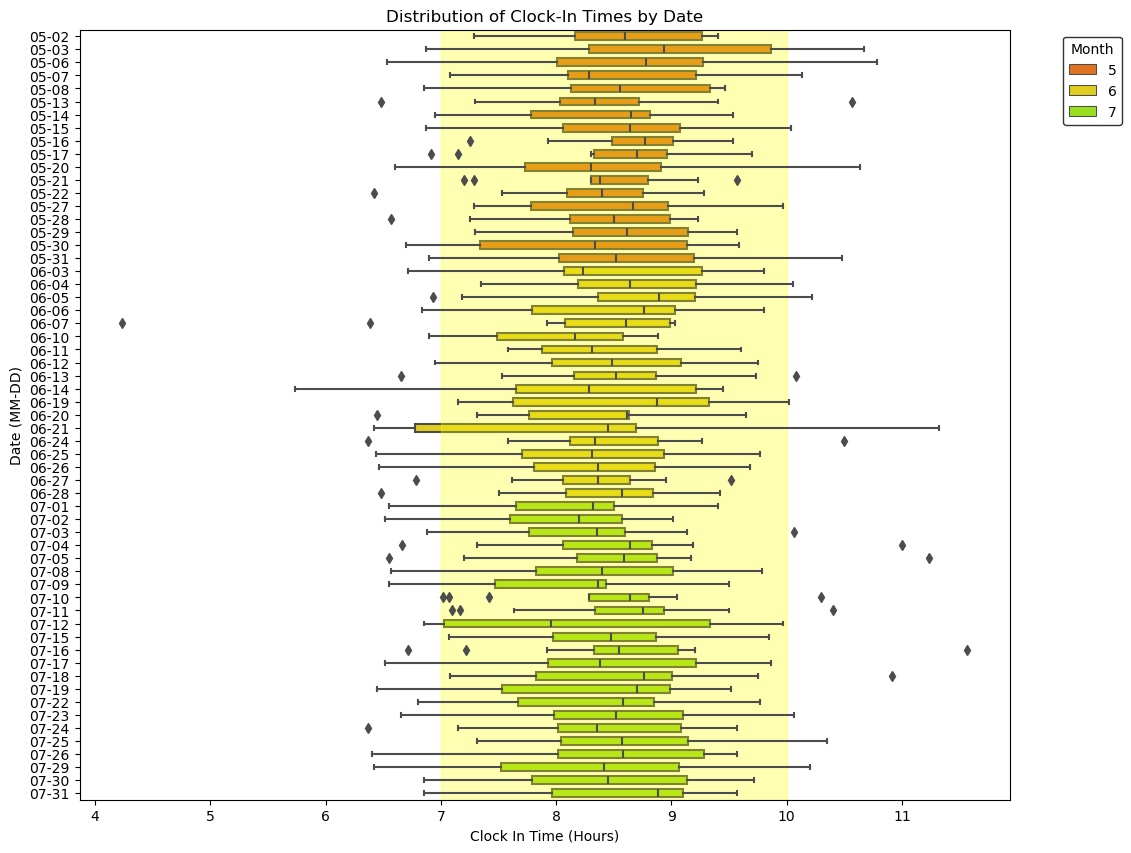

In [3]:

# Extract month from 'Tanggal' for coloring
df_filtered.loc[:, 'Month'] = df_filtered['Tanggal'].apply(lambda x: int(x.split('-')[0]))

# Define a color palette for the months
month_palette = sns.color_palette("hsv", 12)

# Plot transposed box plot by date with highlighted range and month-based colors
plt.figure(figsize=(12, 10))
sns.boxplot(y='Tanggal', x='Clock In Hours', data=df_filtered, hue='Month', palette=month_palette, order=sorted(df_filtered['Tanggal'].unique(), key=lambda x: datetime.strptime(x, '%m-%d')), width=0.6, dodge=False)
plt.axvspan(7, 10, color='yellow', alpha=0.3)
plt.ylabel('Date (MM-DD)')
plt.xlabel('Clock In Time (Hours)')
plt.title('Distribution of Clock-In Times by Date')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left',frameon=True, facecolor='white', edgecolor='black')
plt.show()


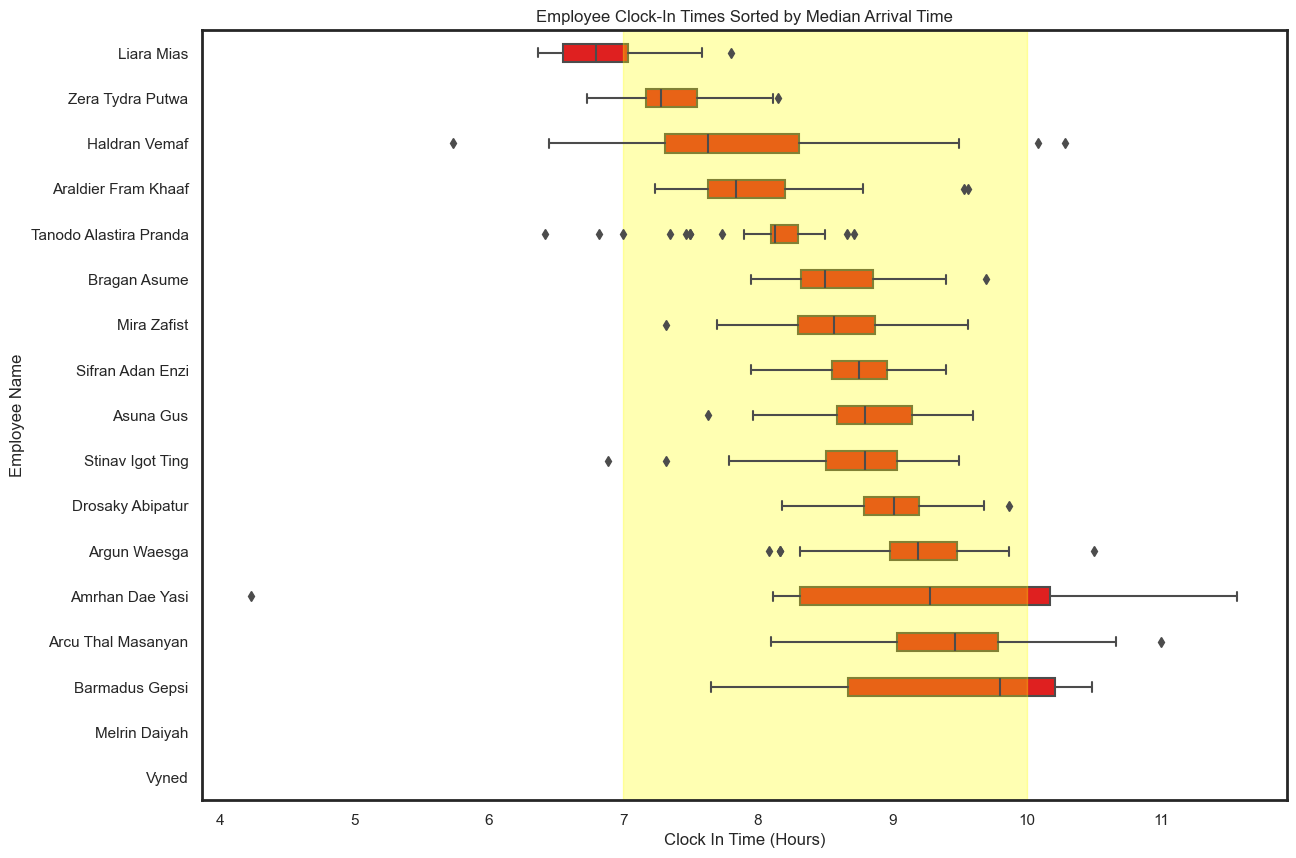

In [47]:
# Filter out irrelevant statuses
df_filtered = df[~df['Status'].isin(['Libur', 'CB', 'SAKIT', 'WFS'])].copy()

# Calculate the median clock-in time for each employee
medians = df_filtered.groupby('Nama')['Clock In Hours'].median()

# Sort employees by the median value in ascending order
sorted_employees = medians.sort_values(ascending=True).index

# Plot box plot by employee name sorted by median clock-in time
plt.figure(figsize=(14, 10))  # Increase the height of the figure
sns.boxplot(y='Nama', x='Clock In Hours', data=df_filtered, order=sorted_employees, width=0.4, color='#ff0000')
plt.axvspan(7, 10, color='yellow', alpha=0.3)
plt.xlabel('Clock In Time (Hours)')
plt.ylabel('Employee Name')
plt.title('Employee Clock-In Times Sorted by Median Arrival Time')
plt.show()

Number of 'Not In' Entries Per Employee by Month

Month              Nama  May  June  July  Total
Rank                                           
1        Barmadus Gepsi    0    13    17     30
2       Amrhan Dae Yasi    6     8     8     22
3          Argun Waesga    0    13     0     13
4             Asuna Gus    0     0     3      3
5            Liara Mias    0     0     1      1
6           Mira Zafist    1     0     0      1
7      Sifran Adan Enzi    0     1     0      1

Number of 'Not Out' Entries Per Employee by Month

Month                 Nama  May  June  July  Total
1          Amrhan Dae Yasi    2     1     1      4
2      Araldier Fram Khaaf    1     2     0      3
3            Haldran Vemaf    1     0     1      2
4               Liara Mias    1     1     0      2
5             Bragan Asume    0     0     1      1
6              Mira Zafist    1     0     0      1


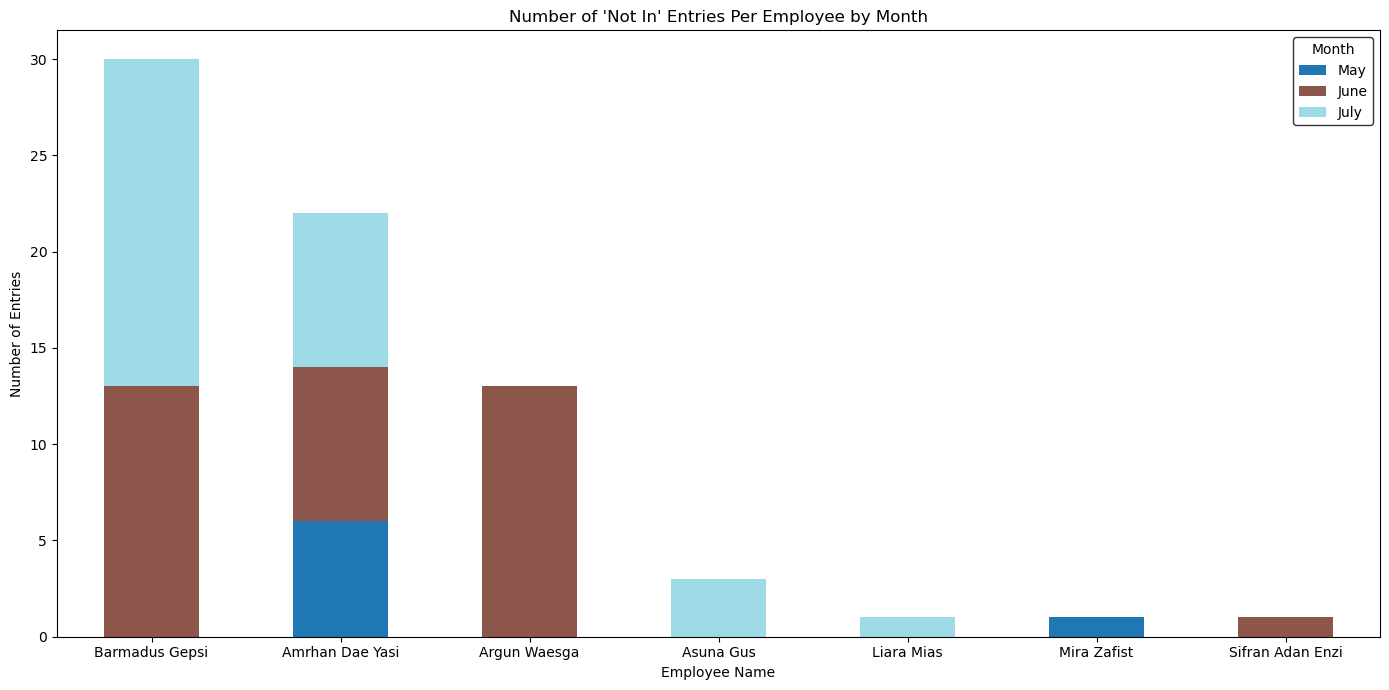

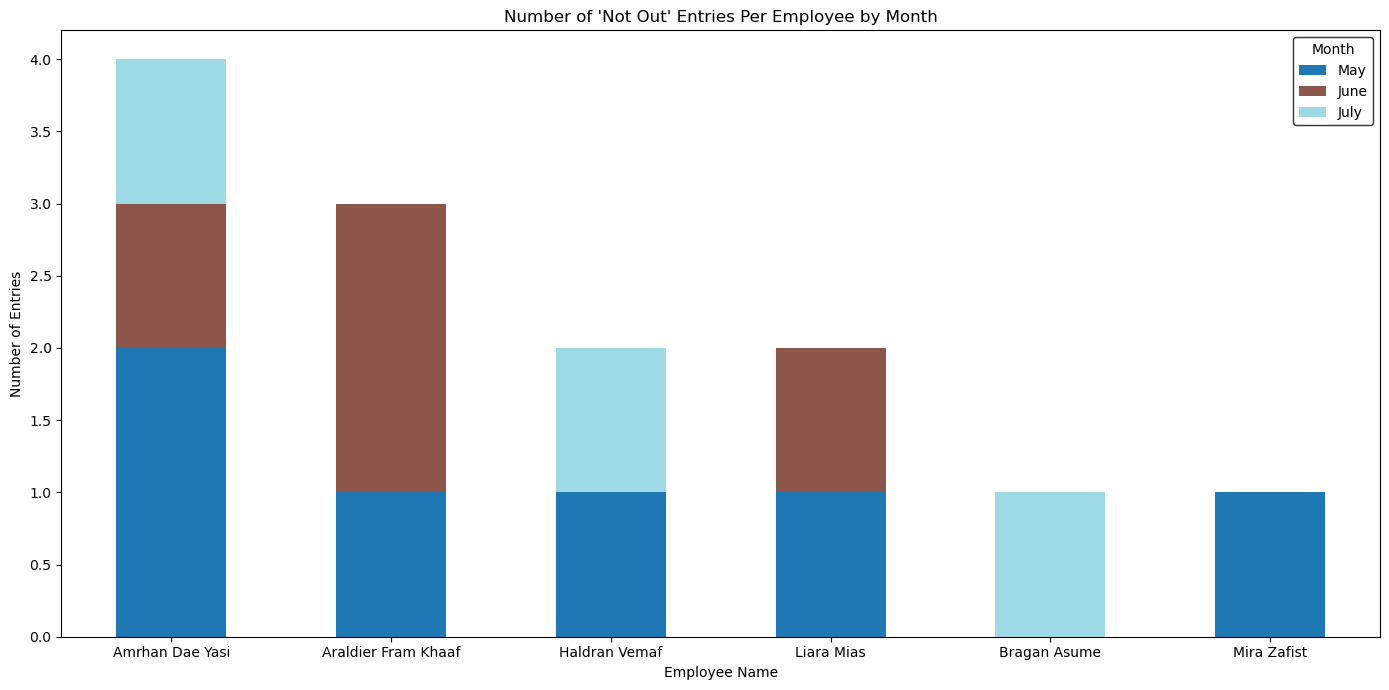

In [3]:
# Extract month name from 'Tanggal'
df['Month'] = df['Tanggal'].dt.strftime('%B')

# Filter for "Not In" status
not_in_df = df[df['Status'] == 'Not In']

# Group by employee and month, then count the "Not In" entries
not_in_counts = not_in_df.groupby(['Nama', 'Month']).size().reset_index(name='Count')

# Pivot the table to have employees as rows and months as columns
pivot_table = not_in_counts.pivot(index='Nama', columns='Month', values='Count').fillna(0)

# Convert counts to integers
pivot_table = pivot_table.astype(int)

# Add a Total column
pivot_table['Total'] = pivot_table.sum(axis=1)

# Reorder columns to have the months in a specific order if needed
month_order = ['May', 'June', 'July']
pivot_table = pivot_table.reindex(columns=month_order + ['Total'], fill_value=0)

# Sort by Total column in descending order
pivot_table = pivot_table.sort_values(by='Total', ascending=False)

# Reset index and rename the first column to 'Rank'
pivot_table.reset_index(inplace=True)
pivot_table.index.names = ['Rank']

# Adjust index to start at 1 instead of 0
pivot_table.index = pivot_table.index + 1


#Not Out
# Filter for "Not Out" status
not_out_df = df[df['Status'] == 'Not Out']

# Group by employee and month, then count the "Not Out" entries
not_out_counts = not_out_df.groupby(['Nama', 'Month']).size().reset_index(name='Count')

# Pivot the table to have employees as rows and months as columns
pivot_table_not_out = not_out_counts.pivot(index='Nama', columns='Month', values='Count').fillna(0)

# Convert counts to integers
pivot_table_not_out = pivot_table_not_out.astype(int)

# Add a Total column
pivot_table_not_out['Total'] = pivot_table_not_out.sum(axis=1)

# Reorder columns to have the months in a specific order if needed
pivot_table_not_out = pivot_table_not_out.reindex(columns=month_order + ['Total'], fill_value=0)

# Sort by Total column in descending order
pivot_table_not_out = pivot_table_not_out.sort_values(by='Total', ascending=False)

# Reset index and rename the first column to 'Rank'
pivot_table_not_out.reset_index(inplace=True)
pivot_table_not_out.rename(columns={'index': 'Rank'}, inplace=True)

# Adjust index to start at 1 instead of 0
pivot_table_not_out.index = pivot_table_not_out.index + 1

# Display the final table
print(color.BOLD +"Number of 'Not In' Entries Per Employee by Month\n"+color.END )
print(pivot_table)

print(color.BOLD +"\nNumber of 'Not Out' Entries Per Employee by Month\n"+color.END)
print(pivot_table_not_out)


# Plot stacked bar charts for 'Not In'
plt.rcParams["figure.figsize"] = (14, 7)
pivot_table.set_index('Nama')[month_order].plot(kind='bar', stacked=True, colormap='tab20', edgecolor='none')
plt.xlabel('Employee Name')
plt.ylabel('Number of Entries')
plt.title("Number of 'Not In' Entries Per Employee by Month")
plt.xticks(rotation=0, ha='center')
plt.legend(title='Month',frameon=True, facecolor='white', edgecolor='black')
plt.tight_layout()
plt.show()

# Plot stacked bar charts for 'Not Out'
plt.rcParams["figure.figsize"] = (14, 7)
pivot_table_not_out.set_index('Nama')[month_order].plot(kind='bar', stacked=True, colormap='tab20', edgecolor='none')
plt.xlabel('Employee Name')
plt.ylabel('Number of Entries')
plt.title("Number of 'Not Out' Entries Per Employee by Month")
plt.xticks(rotation=0, ha='center')
plt.legend(title='Month',frameon=True, facecolor='white', edgecolor='black')
plt.tight_layout()
plt.show()

In [5]:
# Function to convert time to minutes
def time_to_minutes(time):
    if pd.isna(time):
        return None
    return time.hour * 60 + time.minute
# Convert times to minutes for comparison
df['Absen Masuk Minutes'] = df['Absen Masuk'].apply(time_to_minutes)
df['Jam Masuk Minutes'] = df['Jam Masuk'].apply(time_to_minutes)
df['Jam Pulang Minutes'] = df['Jam Masuk'].apply(time_to_minutes)
df['Absen Pulang Minutes'] = df['Jam Masuk'].apply(time_to_minutes)

# Calculate the difference in minutes
df['Difference Minutes'] = df['Absen Masuk Minutes'] - df['Jam Masuk Minutes'] - 180
df['Difference Minutes'] = df['Difference Minutes'].fillna(0) .astype(int)

# Filter rows where the difference is greater than zero
filtered_df = df[(df['Difference Minutes'] > 0) & (df['Absen Masuk'] != df['Absen Pulang'])]

# Display the filtered data
print(filtered_df[['Tanggal', 'NIP', 'Nama', 'Absen Masuk', 'Difference Minutes']])

        Tanggal       NIP                Nama Absen Masuk  Difference Minutes
23   2024-06-24  22165128        Argun Waesga    10:30:00                  30
48   2024-06-19  20510838  Arcu Thal Masanyan    10:01:00                   1
94   2024-06-05  16136882      Barmadus Gepsi    10:13:00                  13
192  2024-06-13  23235161       Haldran Vemaf    10:05:00                   5
273  2024-06-04  20401903     Amrhan Dae Yasi    10:03:00                   3
290  2024-06-21  20401903     Amrhan Dae Yasi    11:19:00                  79
543  2024-05-03  20510838  Arcu Thal Masanyan    10:40:00                  40
553  2024-05-13  20510838  Arcu Thal Masanyan    10:34:00                  34
555  2024-05-15  20510838  Arcu Thal Masanyan    10:02:00                   2
560  2024-05-20  20510838  Arcu Thal Masanyan    10:38:00                  38
633  2024-05-31  16136882      Barmadus Gepsi    10:29:00                  29
698  2024-05-03  23235161       Haldran Vemaf    10:17:00       

In [6]:
# Convert minutes to hhmm
def minutes_to_hhmm(minutes):
    hours = minutes // 60
    mins = minutes % 60
    return f'{hours:02}:{mins:02}'

# Extract month name from 'Tanggal'
df['Month'] = df['Tanggal'].dt.strftime('%B')

# Filter rows where the difference is greater than zero and 'Absen Masuk' != 'Absen Pulang'
filtered_df = df[(df['Difference Minutes'] > 0) & (df['Absen Masuk'] != df['Absen Pulang'])]

# Group by employee name and month, then sum the differences
grouped_df = filtered_df.groupby(['Nama', 'Month'])['Difference Minutes'].sum().reset_index()

# Pivot the table to have employees as rows and months as columns
pivot_table = grouped_df.pivot(index='Nama', columns='Month', values='Difference Minutes').fillna(0)

# Convert counts to integers
pivot_table = pivot_table.astype(int)

# Add a Total column
pivot_table['Total'] = pivot_table.sum(axis=1)
pivot_table['Total (Hours)'] = pivot_table['Total'].apply(minutes_to_hhmm)

# Reorder columns to have the months in a specific order if needed
month_order = ['May', 'June', 'July']
pivot_table = pivot_table.reindex(columns=month_order + ['Total'] + ['Total (Hours)'], fill_value=0).sort_values(by='Total', ascending=False)

# Reset index and rename the first column to 'Rank'
pivot_table.reset_index(inplace=True)
pivot_table.index.names = ['Rank']

# Adjust index to start at 1 instead of 0
pivot_table.index = pivot_table.index + 1

# Display the table with a title
print("Total Lateness Per Employee by Month\n")
print(pivot_table)

Total Lateness Per Employee by Month

Month                Nama  May  June  July  Total Total (Hours)
Rank                                                           
1         Amrhan Dae Yasi   84    82   269    435         07:15
2      Arcu Thal Masanyan  114     1   101    216         03:36
3          Barmadus Gepsi   29    13    12     54         00:54
4            Argun Waesga    0    30     0     30         00:30
5           Haldran Vemaf   17     5     0     22         00:22


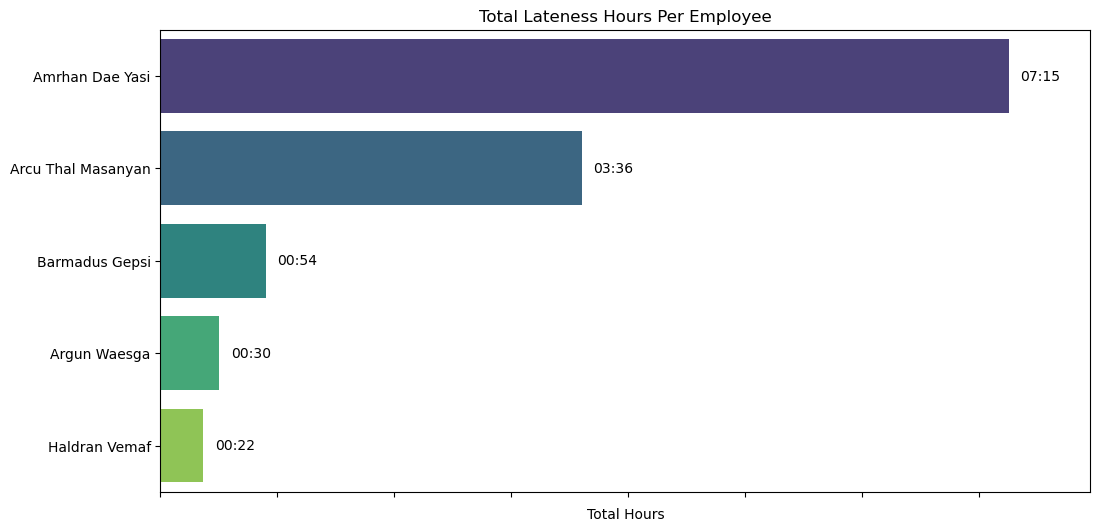

In [7]:
# Apply the function to the 'Total' column and create a new 'Total HH:MM' column
pivot_table['Total HH:MM'] = pivot_table['Total'].apply(minutes_to_hhmm)

# Convert minutes to hours for the bar chart
pivot_table['Total Hours'] = pivot_table['Total'] / 60

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Total Hours', y='Nama', data=pivot_table, palette='viridis').set(xticklabels=[])

# Add labels and title
plt.xlabel('Total Hours')
plt.ylabel('')
plt.title('Total Lateness Hours Per Employee')

# Annotate each bar with the Total HH:MM value using text()
for index, row in pivot_table.iterrows():
    plt.text(row['Total Hours'] +0.10, index-1, row['Total HH:MM'], color='black', va='center')

# Set xlim to max_hours + 1

plt.xlim(0, pivot_table['Total Hours'].max() + 0.7)

plt.show()

Total Overtime Per Employee by Month

Month                    Nama  Year   May  June  July  Total Total (Hours)
0                       Vyned  2024     0     0     0      0         00:00
1               Melrin Daiyah  2024     0     0     0      0         00:00
2              Barmadus Gepsi  2024     0   174    91    265         04:25
3      Tanodo Alastira Pranda  2024   149   162   288    599         09:59
4            Stinav Igot Ting  2024   253   271   223    747         12:27
5             Amrhan Dae Yasi  2024   250   695   446   1391         23:11
6            Sifran Adan Enzi  2024   413   776   554   1743         29:03
7                 Mira Zafist  2024   452   418   967   1837         30:37
8          Arcu Thal Masanyan  2024   702   774   507   1983         33:03
9                   Asuna Gus  2024   995   346   982   2323         38:43
10        Araldier Fram Khaaf  2024   530   603  1540   2673         44:33
11           Zera Tydra Putwa  2024   818   692  1659   3169  

<Figure size 1200x800 with 0 Axes>

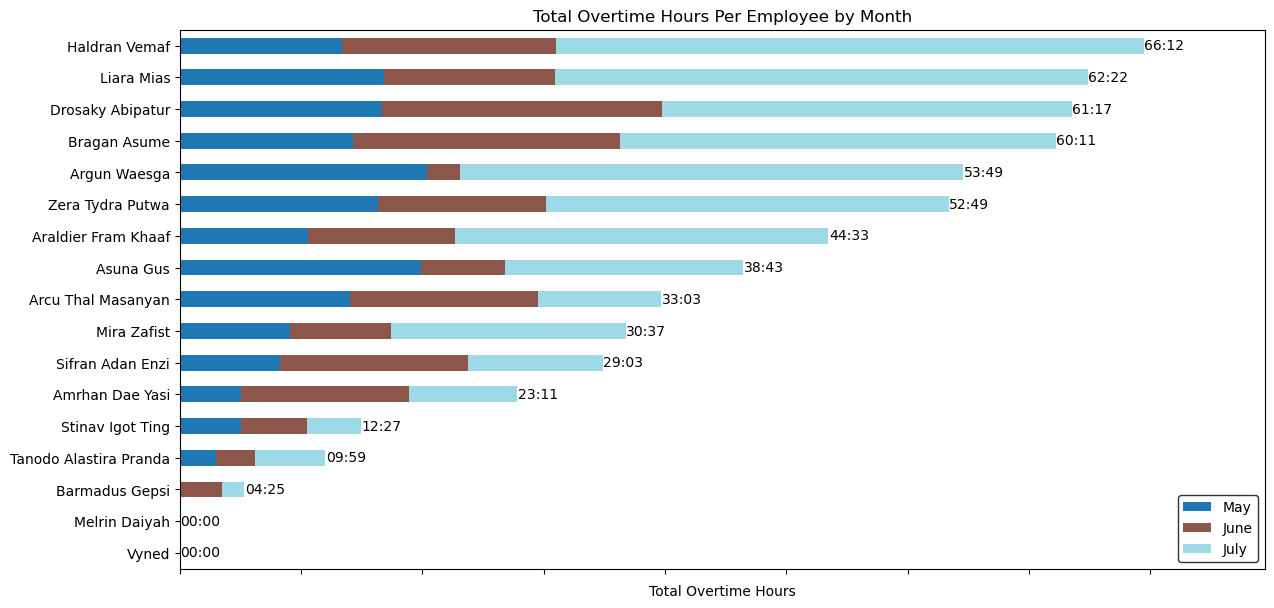

In [8]:
# Ensure 'Overtime' is a string and handle NaN values
df['Overtime'] = df['Overtime'].fillna('00:00').astype(str)

# Convert 'Overtime' to minutes
def hhmm_to_minutes(hhmm):
    if pd.isna(hhmm) or hhmm == '':  # Handle empty or NaN values
        return 0
    h, m = map(int, hhmm.split(':'))
    return h * 60 + m

df['Overtime Minutes'] = df['Overtime'].apply(hhmm_to_minutes)

# Extract month name and year
df['Month'] = df['Tanggal'].dt.strftime('%B')
df['Year'] = df['Tanggal'].dt.year

# Group by employee, month, and year, then sum the overtime minutes
monthly_overtime = df.groupby(['Nama', 'Year', 'Month'])['Overtime Minutes'].sum().reset_index()

# Pivot table to show total overtime per employee per month
pivot_table_overtime = monthly_overtime.pivot_table(index=['Nama', 'Year'], columns='Month', values='Overtime Minutes', fill_value=0)
pivot_table_overtime = pivot_table_overtime.astype(int)

# Convert minutes to HH:MM
def minutes_to_hhmm(minutes):
    hours = minutes // 60
    mins = minutes % 60
    return f'{hours:02}:{mins:02}'

# Add a Total column in HH:MM format
pivot_table_overtime['Total'] = pivot_table_overtime.sum(axis=1)
pivot_table_overtime['Total (Hours)'] = pivot_table_overtime['Total'].apply(minutes_to_hhmm)

# Reorder columns to have the months in the specified order
month_order = ['May', 'June', 'July']
pivot_table_overtime = pivot_table_overtime.reindex(columns=month_order + ['Total', 'Total (Hours)'], fill_value=0)

# Sort by 'Total' in descending order
pivot_table_overtime.sort_values(by='Total', ascending=True, inplace=True)

# Reset index for plotting
pivot_table_overtime.reset_index(inplace=True)

# Display the table with a title
print("Total Overtime Per Employee by Month\n")
print(pivot_table_overtime)

# Prepare data for plotting
months = pivot_table_overtime.columns[2:-2]  # Select month columns for plotting
data_for_plot = pivot_table_overtime.set_index('Nama')[months]  # Use employee names as index

# Plot the stacked horizontal bar chart
plt.figure(figsize=(12, 8))
ax = data_for_plot.plot(kind='barh', stacked=True, colormap='tab20', edgecolor='none')

# Add labels and title
plt.xlabel('Total Overtime Hours')
plt.ylabel('')
plt.title('Total Overtime Hours Per Employee by Month')

# Annotate the total hours in HH:MM format at the end of each bar
for index, row in pivot_table_overtime.iterrows():
    total_minutes = row['Total']
    total_hhmm = minutes_to_hhmm(total_minutes)
    plt.text(row['Total'] + 2, index, f'{total_hhmm}', va='center', color='black')


# Hide the x-axis labels but keep the axis visible
ax.set_xticks(ax.get_xticks())  # Ensure ticks are displayed
ax.set_xticklabels(['' for _ in ax.get_xticks()])  # Remove tick labels


# Adjust xlim to add padding
plt.xlim(0, pivot_table_overtime['Total'].max() + 500)

# Adjust the legend properties
plt.legend(frameon=True, facecolor='white', edgecolor='black', loc = 'lower right')

# Display the plot
plt.show()

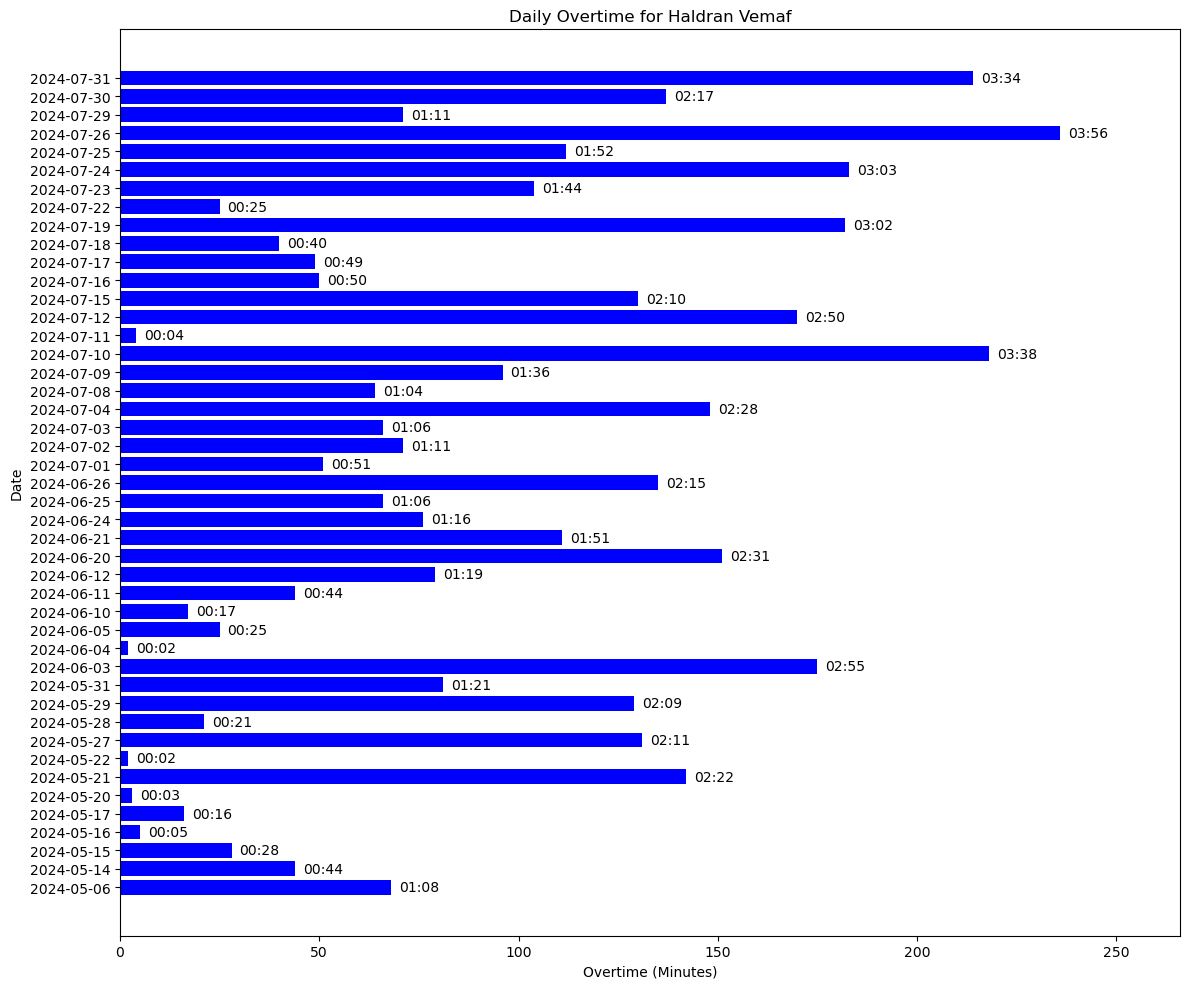

In [9]:
# Filter data for the employee "Haldran Vemaf"
employee_name = "Haldran Vemaf"
df_employee = df[df['Nama'] == employee_name].copy()

# Extract date
df_employee['Date'] = df_employee['Tanggal'].dt.date

# Filter out overtime of 0 minutes
df_employee = df_employee[df_employee['Overtime Minutes'] > 0]

# Group by date and sum the overtime minutes
daily_overtime = df_employee.groupby('Date')['Overtime Minutes'].sum().reset_index()

# Convert minutes to HH:MM for display
daily_overtime['Overtime (HH:MM)'] = daily_overtime['Overtime Minutes'].apply(lambda x: f"{x // 60:02}:{x % 60:02}")

# Plot the daily overtime for the employee as a horizontal bar chart
plt.figure(figsize=(12, 10))  # Adjusted figure size to avoid large dimensions
plt.barh(daily_overtime['Date'].astype(str), daily_overtime['Overtime Minutes'], color='blue')

# Add labels and title
plt.ylabel('Date')
plt.xlabel('Overtime (Minutes)')
plt.title(f'Daily Overtime for {employee_name}')

# Annotate the bars with overtime in HH:MM format
for index, row in daily_overtime.iterrows():
    plt.text(row['Overtime Minutes'] + 2, index, row['Overtime (HH:MM)'], va='center', color='black')

# Adjust xlim to add padding
plt.xlim(0, daily_overtime['Overtime Minutes'].max() + 30)

# Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

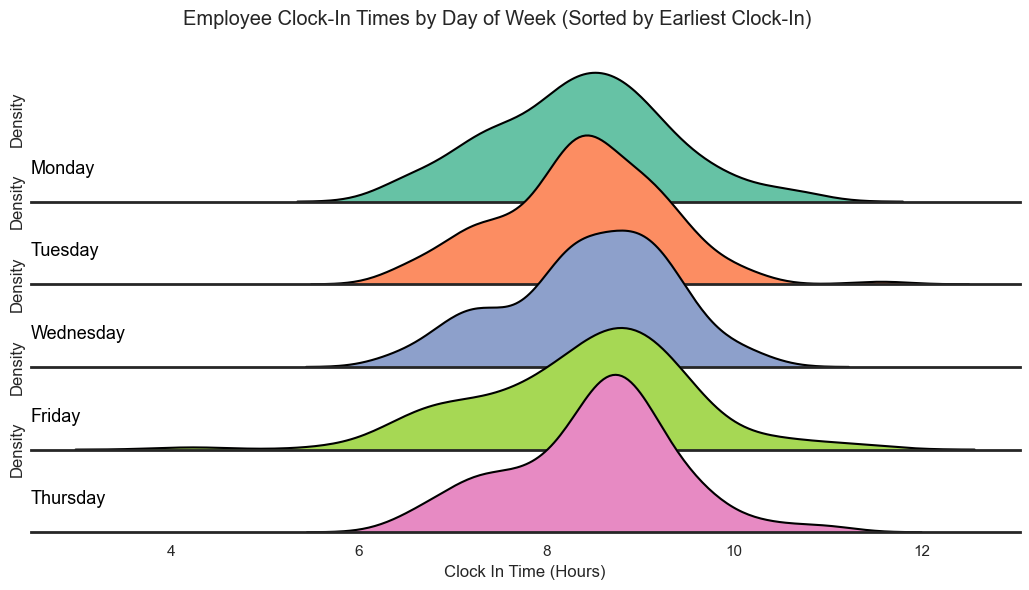

In [10]:
# Extract hour and minute from 'Absen Masuk' to create 'Clock In Hours'
def time_to_hours(t):
    if pd.isna(t):
        return np.nan
    return t.hour + t.minute / 60

df['Clock In Hours'] = df['Absen Masuk'].apply(time_to_hours)

# Filter out irrelevant statuses
df_filtered = df[~df['Status'].isin(['Libur', 'CB', 'SAKIT', 'WFS'])].copy()

# Extract the day of the week from 'Tanggal'
df_filtered['Day of Week'] = df_filtered['Tanggal'].dt.day_name()

# Filter only weekdays (Monday to Friday)
df_filtered = df_filtered[df_filtered['Day of Week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]

# Replace infinite values with NaN
df_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)

# Calculate median clock-in time for each day of the week
median_clock_in_times = df_filtered.groupby('Day of Week')['Clock In Hours'].median().sort_values()

# Get the sorted order of days
sorted_days = median_clock_in_times.index

# Create the ridge plot
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth': 2})
palette = sns.color_palette("Set2", 5)

g = sns.FacetGrid(df_filtered, palette=palette, row="Day of Week", hue="Day of Week", aspect=9, height=1.2,
                  row_order=sorted_days)
g.map_dataframe(sns.kdeplot, x="Clock In Hours", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="Clock In Hours", color='black')

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Day of Week")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="Clock In Time (Hours)")
g.despine(left=True)
plt.suptitle('Employee Clock-In Times by Day of Week (Sorted by Earliest Clock-In)', y=0.98)
plt.show()

In [11]:
# Function to convert decimal hours to HH:MM
def hours_to_hhmm(hours):
    if pd.isna(hours):
        return np.nan
    h = int(hours)
    m = int((hours - h) * 60)
    return f'{h:02}:{m:02}'

# Assuming df_filtered and median_clock_in_times are already defined

# Calculate median and variance for each day of the week
median_clock_in_times = df_filtered.groupby('Day of Week')['Clock In Hours'].median()
variance_clock_in_times = df_filtered.groupby('Day of Week')['Clock In Hours'].var()

# Create a DataFrame to hold the results
stats_df = pd.DataFrame({
    'Median': median_clock_in_times,
    'Variance': variance_clock_in_times
})

# Convert Median and Variance from decimal to HH:MM
stats_df['Median HH:MM'] = stats_df['Median'].apply(hours_to_hhmm)
stats_df['Variance HH:MM'] = stats_df['Variance'].apply(hours_to_hhmm)

# Sort by Median
sorted_by_median = stats_df.sort_values(by='Median')

# Sort by Variance
sorted_by_variance = stats_df.sort_values(by='Variance')

# Print the results
print("Sorted by Median:\n")
print(sorted_by_median[['Median HH:MM', 'Variance HH:MM']])

print("\nSorted by Variance:\n")
print(sorted_by_variance[['Median HH:MM', 'Variance HH:MM']])

Sorted by Median:

            Median HH:MM Variance HH:MM
Day of Week                            
Monday             08:24          00:51
Tuesday            08:24          00:43
Wednesday          08:31          00:44
Friday             08:33          01:13
Thursday           08:37          00:46

Sorted by Variance:

            Median HH:MM Variance HH:MM
Day of Week                            
Tuesday            08:24          00:43
Wednesday          08:31          00:44
Thursday           08:37          00:46
Monday             08:24          00:51
Friday             08:33          01:13


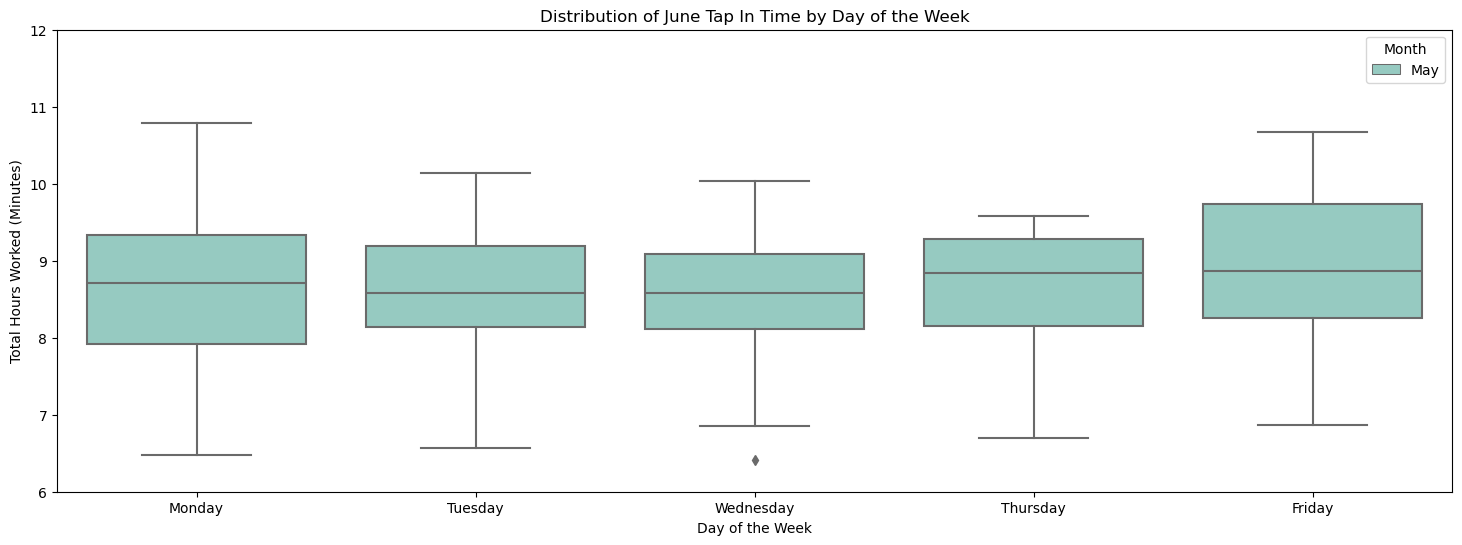

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from CSV
file_path = 'C:\\Users\\farrel.mahardika\\tdm_presence_aliased.csv'
df = pd.read_csv(file_path)

# Convert the 'Tanggal' column to datetime format
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')

# Convert 'Total Jam' from HH:MM format to minutes
def convert_to_minutes(time_str):
    if pd.isna(time_str) or time_str == '':
        return None
    try:
        h, m = map(int, time_str.split(':'))
        return h * 60 + m
    except ValueError:
        return None

df['Total Jam Minutes'] = df['Absen Masuk'].apply(convert_to_minutes) / 60

# Filter for June, July, and August
df_filtered = df[df['Tanggal'].dt.month.isin([5])]

# Exclude Saturdays and Sundays
df_filtered = df_filtered[~df_filtered['Tanggal'].dt.day_name().isin(['Saturday', 'Sunday'])]

# Extract day of the week and month
df_filtered['day_of_week'] = df_filtered['Tanggal'].dt.day_name()
df_filtered['month'] = df_filtered['Tanggal'].dt.month_name()

# Create the box plot
plt.figure(figsize=(18, 6))
sns.boxplot(x='day_of_week', y='Total Jam Minutes', hue='month', data=df_filtered, palette="Set3", order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

# Set y-axis limits
plt.ylim(6, 12)

# Customize the plot
plt.title('Distribution of June Tap In Time by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Hours Worked (Minutes)')
plt.legend(title='Month')
plt.show()
